In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

from functions import *

import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *

In [2]:
"""plt.rcParams.update({
"text.usetex": True,
"font.family": 'DejaVu Sans',
"font.serif": ["Computer Modern Roman"],
"font.size": 20})"""

'plt.rcParams.update({\n"text.usetex": True,\n"font.family": \'DejaVu Sans\',\n"font.serif": ["Computer Modern Roman"],\n"font.size": 20})'

In [3]:
#Maps with mean over time:
#Just make maps with emissions and difference in emissions
#Summer and winter
#Looking at the ghan components
#Column burden og SOA (cb_SOA_NA + cb_SOA_A1) 
#Changes in N_AER (total aerosol number) 
#Cloud droplet radius and number concentration (cloud top) 
#LWP. 
#evapotranspiration

In [4]:
processed_path = '../../processed-data/postprocessing/' #/Users/adelezaini/Desktop/master-thesis/processed-data/output/IDEAL-ON_BVOC_20082012.nc
casealias = ['CTRL','CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
date = '20082012'

In [5]:
def load_dataset_dict(variable):
    ds_dict = {}
    for case in casealias:
        ds = xr.open_dataset(processed_path+case+'_'+variable+'_'+date+'.nc')
        ds_dict[case] = convert360_180(ds)
        #ds_dict[case] = ds.where(ds.LANDFRAC.mean('time')>0.).where(ds.lat>45., drop=True)
    return ds_dict

In [11]:
def plot_difference(da_dict, case1, case2, variable, ax = None, lev=False, **kwargs):
    
    diff = (da_dict[case1][variable].mean('time')-da_dict[case2][variable].mean('time'))#/da_dict[case2][variable].groupby('time.year').sum('time').mean('year')
    if lev: diff=diff.sum('lev')#.where(da_dict[case1].LANDFRAC.mean('time')>0.)
    single_pft_map(diff, ax = ax, title=case1+' – '+case2, cmap='RdBu_r', extent_lat =45.,**kwargs)
        
def plot_difference_by_season(da_dict, case1, case2, variable, title, lev=False,**kwargs):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    
    diff = (da_dict[case1][variable].groupby('time.season').mean('time')-da_dict[case2][variable].groupby('time.season').mean('time'))
    if lev: diff=diff.sum('lev').where(da_dict[case1].LANDFRAC.mean('time')>0.)
        
    fig, axes = plt.subplots(1,4, figsize=[17,5], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)
    
    for i, season in enumerate(seasons):
        single_pft_map(diff.sel(season=season), ax = axes.flat[i], title=season, cmap='RdBu_r', extent_lat =45.,**kwargs)
    plt.suptitle(title+': '+case1+' – '+case2, size=15)
    plt.show()

## Ghan components

In [19]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
radiative = load_dataset_dict('RADIATIVE')

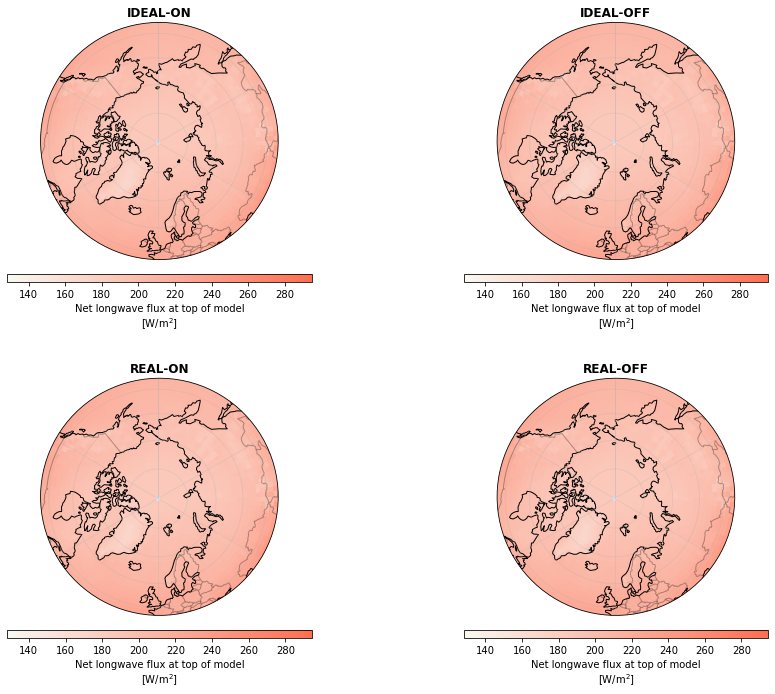

In [21]:
cmp = sequential_colormap('#ff6f52', '#fafaf4')
fig, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=[15,12], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

for i, case in enumerate(casealias[1:]):
    single_pft_map(radiative[case]['FLNT'].mean('time'),ax = axes.flat[i], extent_lat =45.,
                   title=case, cmap=cmp, show=False)

In [14]:
radiative['IDEAL-ON']

<xarray.Dataset>
Dimensions:    (time: 60, lat: 96, lon: 144, nbnd: 2, lev: 32, ilev: 33)
Coordinates:
  * ilev       (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lev        (lev) float64 3.643 7.595 14.36 24.61 ... 936.2 957.5 976.3 992.6
  * time       (time) datetime64[ns] 2008-01-15 2008-02-15 ... 2012-12-15
Dimensions without coordinates: nbnd
Data variables: (12/29)
    LANDFRAC   (time, lat, lon) float32 ...
    GRIDAREA   (time, lat, lon) float32 ...
    gw         (time, lat) float64 ...
    date       (time) int32 ...
    time_bnds  (time, nbnd) datetime64[ns] ...
    P0         (time) float64 ...
    ...         ...
    SWDIR      (time, lat, lon) float32 ...
    LWDIR      (time, lat, lon) float32 ...
    DIR        (time, lat, lon) float32 ...
    NCFT       (time, lat, lon) float32 ...
    SW_rest    (time, lat, lon) float32 ...
    LW_rest    (time, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              IDEAL-ON_2000_f19_f19
    logname:           adelez
    host:              
    initial_file:      IDEAL_2000_spinup_f19_f19.cam.i.0031-01-01-00000.nc
    topography_file:   /cluster/shared/noresm/inputdata/noresm-only/inputForN...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

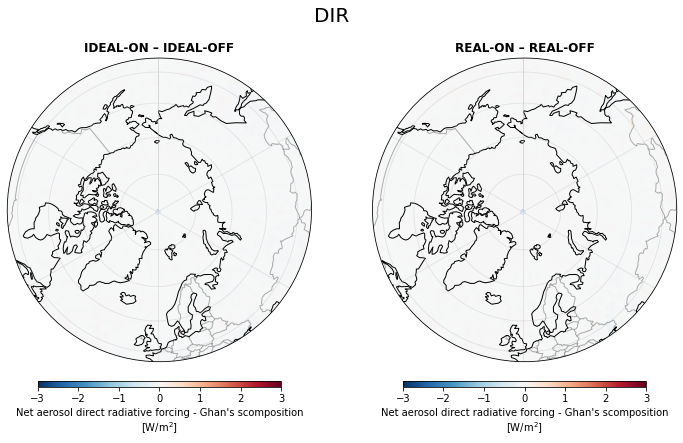

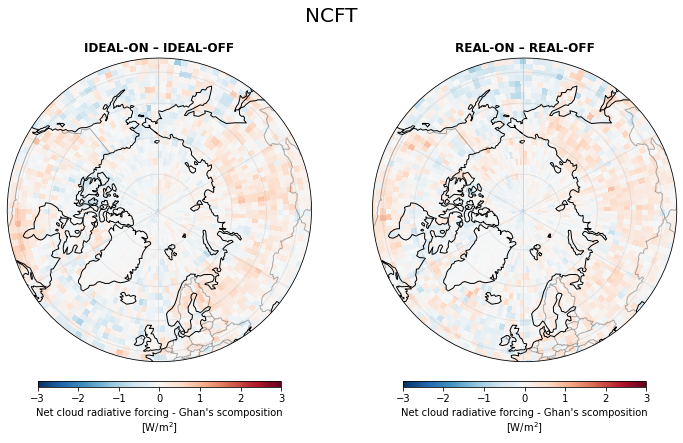

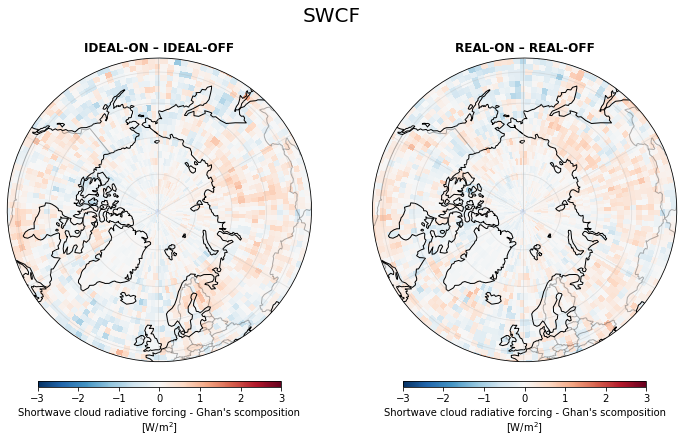

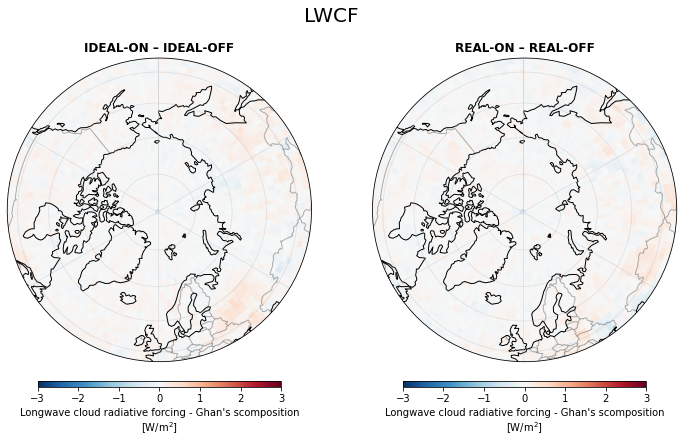

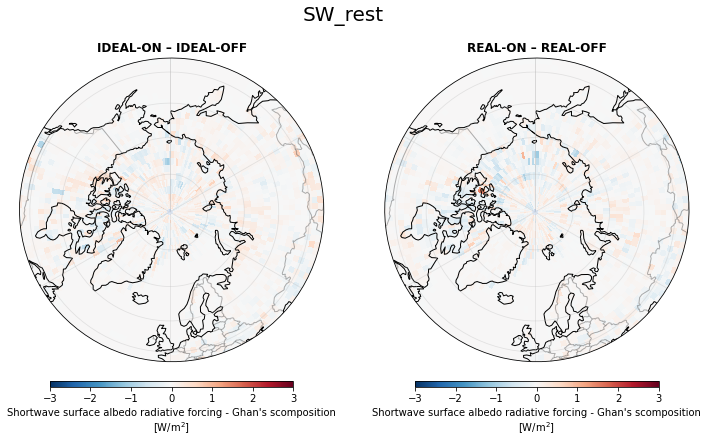

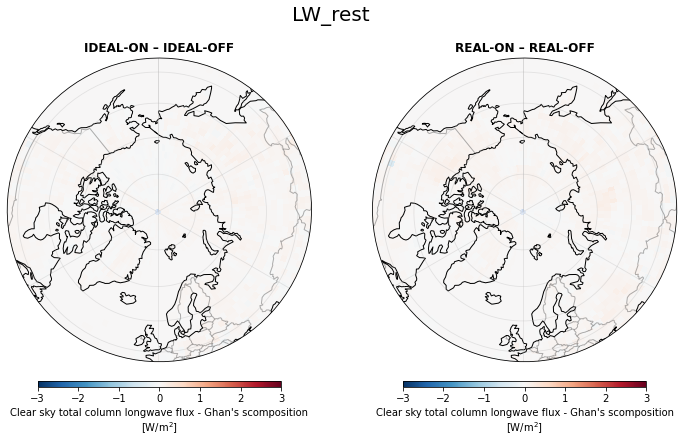

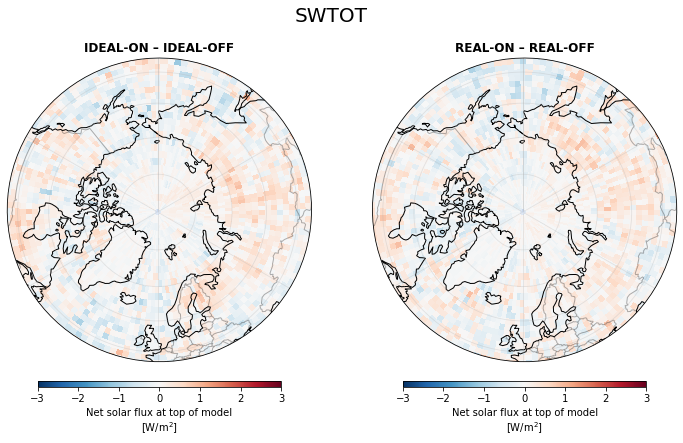

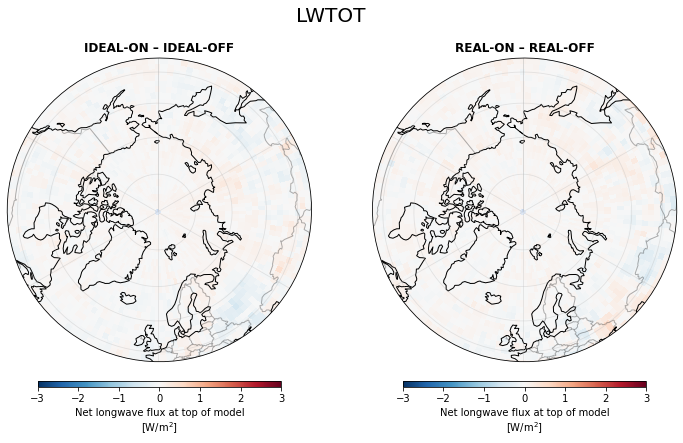

In [22]:
for var in ['DIR', 'NCFT', 'SWCF', 'LWCF', 'SW_rest', 'LW_rest', 'FSNT', 'FLNT']:

    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=[12,7], 
                             subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

    variable=var
    title=var
    if var == 'FSNT': title = 'SWTOT'
    if var == 'FLNT': title = 'LWTOT'
    plot_difference(radiative, 'IDEAL-ON', 'IDEAL-OFF', variable, ax=axes.flat[0], vmax=3)
    plot_difference(radiative, 'REAL-ON', 'REAL-OFF', variable, ax=axes.flat[1], vmax=3)
    plt.suptitle(title, size=20)
    plt.show()

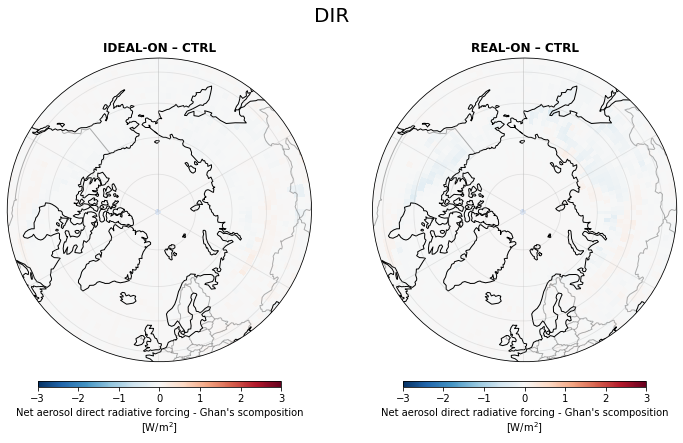

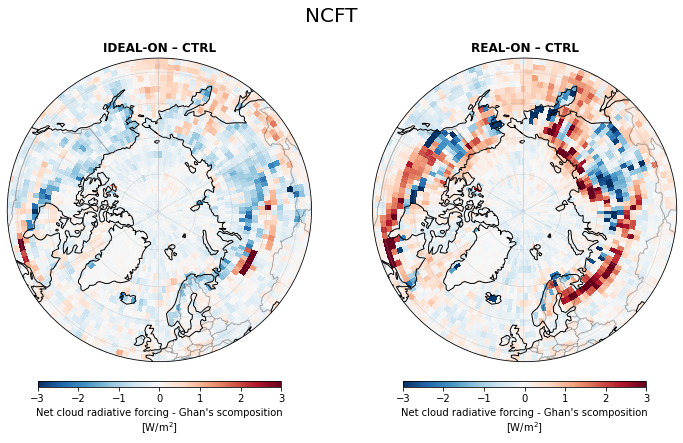

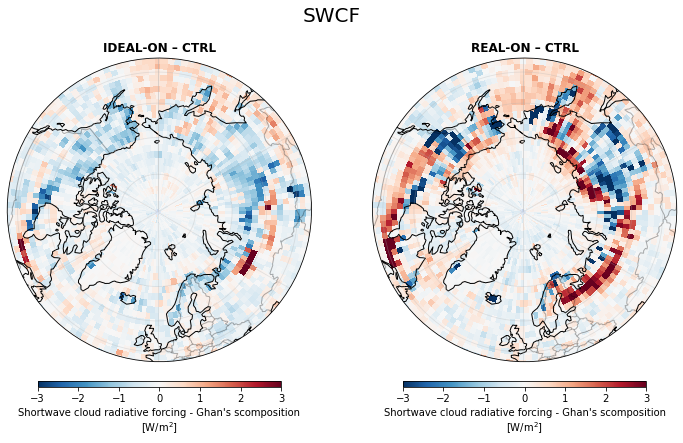

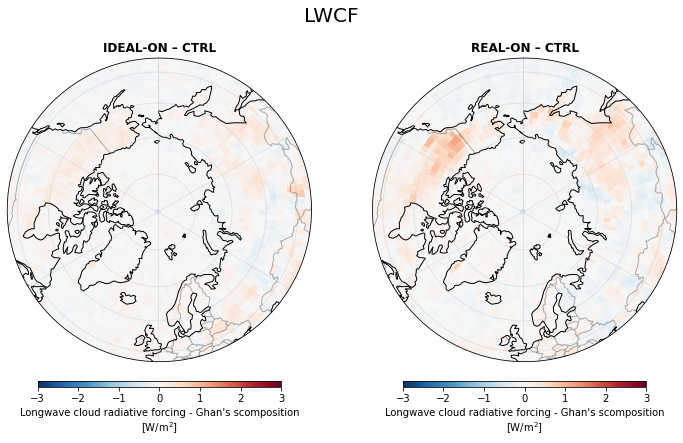

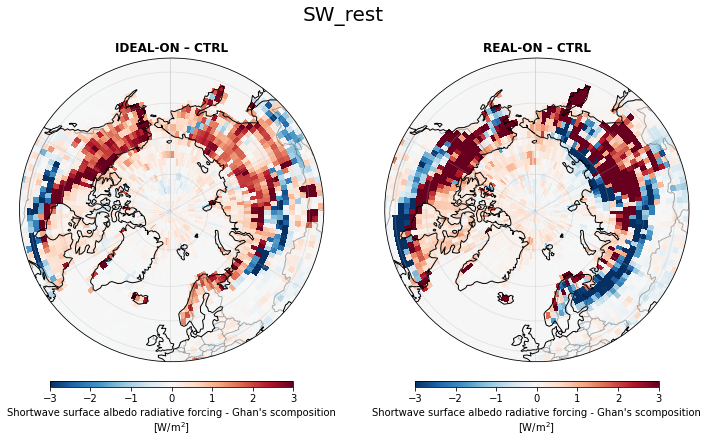

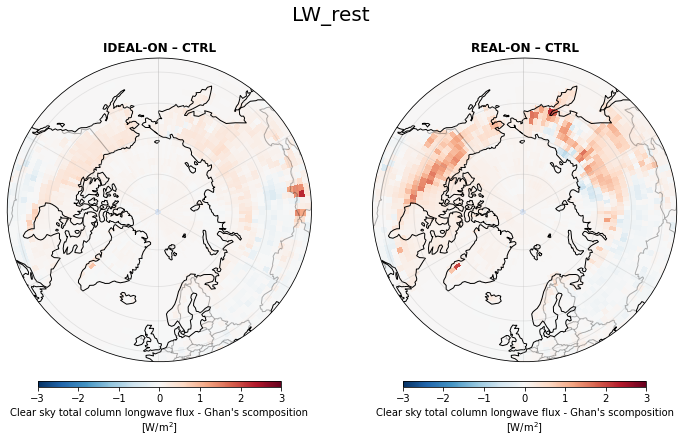

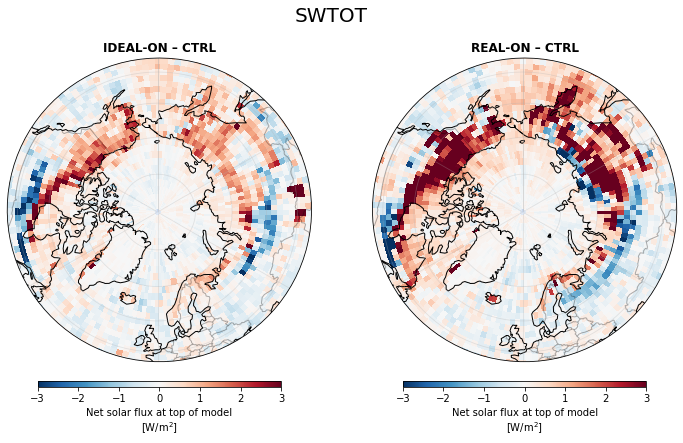

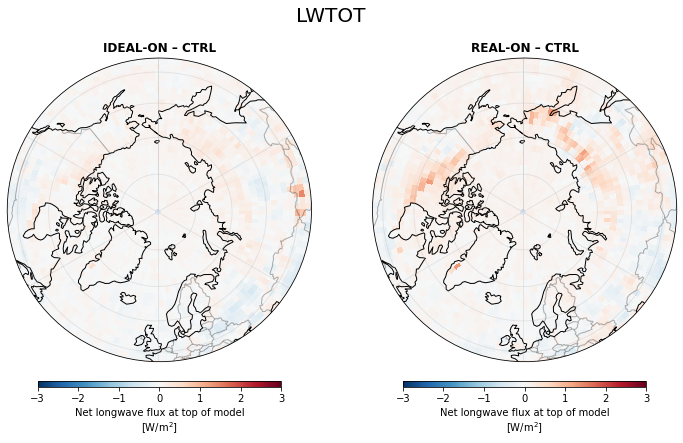

In [23]:
for var in ['DIR', 'NCFT', 'SWCF', 'LWCF', 'SW_rest', 'LW_rest', 'FSNT', 'FLNT']:

    fig, axes = plt.subplots(1,2, sharex=True, sharey=True, figsize=[12,7], 
                             subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)

    variable=var
    title=var
    if var == 'FSNT': title = 'SWTOT'
    if var == 'FLNT': title = 'LWTOT'
    plot_difference(radiative, 'IDEAL-ON', 'CTRL', variable, ax=axes.flat[0], vmax=3)
    plot_difference(radiative, 'REAL-ON', 'CTRL', variable, ax=axes.flat[1], vmax=3)
    plt.suptitle(title, size=20)
    plt.show()